In [1]:
import os, sys
import warnings
import tensorflow as tf
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import warnings

import argparse
import json

import cv2
import editdistance
from path import Path

from DataLoaderIAM import DataLoaderIAM, Batch
from Model import Model, DecoderType
from SamplePreprocessor import preprocess

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

warnings.filterwarnings('ignore')

In [3]:
class FilePaths:
    "filenames and paths to data"
    fnCharList = '../model/charList.txt'
    fnSummary = '../model/summary.json'
    fnInfer = '../data/test.png'
    fnCorpus = '../data/corpus.txt'


def write_summary(charErrorRates, wordAccuracies):
    with open(FilePaths.fnSummary, 'w') as f:
        json.dump({'charErrorRates': charErrorRates, 'wordAccuracies': wordAccuracies}, f)


def train(model, loader):
    "train NN"
    epoch = 0  # number of training epochs since start
    summaryCharErrorRates = []
    summaryWordAccuracies = []
    bestCharErrorRate = float('inf')  # best valdiation character error rate
    noImprovementSince = 0  # number of epochs no improvement of character error rate occured
    earlyStopping = 25  # stop training after this number of epochs without improvement
    while True:
        epoch += 1
        print('Epoch:', epoch)

        # train
        print('Train NN')
        loader.trainSet()
        while loader.hasNext():
            iterInfo = loader.getIteratorInfo()
            batch = loader.getNext()
            loss = model.trainBatch(batch)
            print(f'Epoch: {epoch} Batch: {iterInfo[0]}/{iterInfo[1]} Loss: {loss}')

        # validate
        charErrorRate, wordAccuracy = validate(model, loader)

        # write summary
        summaryCharErrorRates.append(charErrorRate)
        summaryWordAccuracies.append(wordAccuracy)
        write_summary(summaryCharErrorRates, summaryWordAccuracies)

        # if best validation accuracy so far, save model parameters
        if charErrorRate < bestCharErrorRate:
            print('Character error rate improved, save model')
            bestCharErrorRate = charErrorRate
            noImprovementSince = 0
            model.save()
        else:
            print(f'Character error rate not improved, best so far: {charErrorRate * 100.0}%')
            noImprovementSince += 1

        # stop training if no more improvement in the last x epochs
        if noImprovementSince >= earlyStopping:
            print(f'No more improvement since {earlyStopping} epochs. Training stopped.')
            break


def validate(model, loader):
    "validate NN"
    print('Validate NN')
    loader.validationSet()
    numCharErr = 0
    numCharTotal = 0
    numWordOK = 0
    numWordTotal = 0
    while loader.hasNext():
        iterInfo = loader.getIteratorInfo()
        print(f'Batch: {iterInfo[0]} / {iterInfo[1]}')
        batch = loader.getNext()
        (recognized, _) = model.inferBatch(batch)

        print('Ground truth -> Recognized')
        for i in range(len(recognized)):
            numWordOK += 1 if batch.gtTexts[i] == recognized[i] else 0
            numWordTotal += 1
            dist = editdistance.eval(recognized[i], batch.gtTexts[i])
            numCharErr += dist
            numCharTotal += len(batch.gtTexts[i])
            print('[OK]' if dist == 0 else '[ERR:%d]' % dist, '"' + batch.gtTexts[i] + '"', '->',
                  '"' + recognized[i] + '"')

    # print validation result
    charErrorRate = numCharErr / numCharTotal
    wordAccuracy = numWordOK / numWordTotal
    print(f'Character error rate: {charErrorRate * 100.0}%. Word accuracy: {wordAccuracy * 100.0}%.')
    return charErrorRate, wordAccuracy


def infer(model, fnImg):
    "recognize text in image provided by file path"
    img = preprocess(cv2.imread(fnImg, cv2.IMREAD_GRAYSCALE), Model.imgSize)
    batch = Batch(None, [img])
    (recognized, probability) = model.inferBatch(batch, True)
#     print(f'Recognized: "{recognized[0]}
#     print(f'Probability: {probability[0]}')
    return (recognized[0],probability[0])

# Create ground truth reference
gt = pd.read_csv('../../collectedData/labels.csv')
gt.text = gt.text.apply(lambda x: x.split())

In [72]:
def main(path):
    tf.compat.v1.reset_default_graph()

    sys.argv = []
    parser = argparse.ArgumentParser(sys.argv)
    parser.add_argument('--train', help='train the NN', action='store_true')
    parser.add_argument('--validate', help='validate the NN', action='store_true')
    parser.add_argument('--decoder', choices=['bestpath', 'beamsearch', 'wordbeamsearch'], default='bestpath',
                        help='CTC decoder')
    parser.add_argument('--batch_size', help='batch size', type=int, default=100)
    parser.add_argument('--data_dir', help='directory containing IAM dataset', type=Path, required=False)
    parser.add_argument('--fast', help='use lmdb to load images', action='store_true')
    parser.add_argument('--dump', help='dump output of NN to CSV file(s)', action='store_true')
    args = parser.parse_args()
    
#     args.validate = True
    args.data_dir = Path(path)
    debug = False
    if debug:
        print("\n********")
        print(args)
        print(vars(args))
        print(args.data_dir)
        print("********\n")

    
    # set chosen CTC decoder
    if args.decoder == 'bestpath':
        decoderType = DecoderType.BestPath
    elif args.decoder == 'beamsearch':
        decoderType = DecoderType.BeamSearch
    elif args.decoder == 'wordbeamsearch':
        decoderType = DecoderType.WordBeamSearch

    # train or validate on IAM dataset
    if args.train or args.validate:
        # load training data, create TF model
        loader = DataLoaderIAM(args.data_dir, args.batch_size, Model.imgSize, Model.maxTextLen, args.fast)

        # save characters of model for inference mode
        open(FilePaths.fnCharList, 'w').write(str().join(loader.charList))

        # save words contained in dataset into file
        open(FilePaths.fnCorpus, 'w').write(str(' ').join(loader.trainWords + loader.validationWords))

        # execute training or validation
        if args.train:
            model = Model(loader.charList, decoderType)
            train(model, loader)
        elif args.validate:
            model = Model(loader.charList, decoderType, mustRestore=True)
            validate(model, loader)

    # infer text on test images
    else:
        df = pd.DataFrame(columns=['Actual','Guess','Conf','Result','Dist','Path'])
        model = Model(open(FilePaths.fnCharList).read(), decoderType, mustRestore=True, dump=args.dump)
        gt = pd.read_csv('../../collectedData/labels.csv')
        gt.text = gt.text.apply(lambda x: x.split())
        for sample in os.listdir(args.data_dir):
            guess, conf = infer(model, os.path.join(args.data_dir,sample))
            
#             actual = re.sub('((\W+\(\d*\))?\.((png)|(jpg)))','',sample)
#             result = actual==guess
            actual = gt[gt.filename.str.contains(path.split('/')[-1])].iloc[0,1]
            result = guess in actual
            if len(actual)>0:
                dist = editdistance.eval(guess, actual)/len(actual)
            else:
                dist=len(guess)
                print('Actual:\t', actual)
                print('Guess:\t', guess)
                print('Conf:\t ', conf)
                print('\t', result)
                print()
            df = df.append(pd.Series([actual, guess, conf, result, dist, os.path.join(args.data_dir,sample)], index = df.columns), ignore_index=True)
            
        return df

In [103]:
if __name__ == '__main__':
    out = {}
    for path in [os.path.join('../../collectedData/sliced/',x) for x in os.listdir('../../collectedData/sliced/')]:
#         if '013' not in path:
#             continue
        if 'marked' in path:
            continue
        try:
            print(path)    
            out[path.split('/')[-1]] = main(path)
#             out = main(path)
#         display(out)
        except:
            print(f'\tERROR on: < {path} >, skipping file')

../../collectedData/sliced/response_001
../../collectedData/sliced/response_002
../../collectedData/sliced/response_003
../../collectedData/sliced/response_004
ERROR on: < ../../collectedData/sliced/response_004 >, skipping file
../../collectedData/sliced/response_005
../../collectedData/sliced/response_007
ERROR on: < ../../collectedData/sliced/response_007 >, skipping file
../../collectedData/sliced/response_008
ERROR on: < ../../collectedData/sliced/response_008 >, skipping file
../../collectedData/sliced/response_009
../../collectedData/sliced/response_010
../../collectedData/sliced/response_011
ERROR on: < ../../collectedData/sliced/response_011 >, skipping file
../../collectedData/sliced/response_012
../../collectedData/sliced/response_013


In [120]:
for key in out.keys():
    print(key)
    df = out[key]
    actual = gt[gt.filename.str.contains(key)].iloc[0,1]
    orig = actual
    correct = []
    for word in df[df.Result].Guess:
        if word in actual:
            correct.append(word)
            actual = actual[actual.index(word)+1:]
    print(correct)
    print(f'{len(correct)}/{len(orig)}: {len(correct)/len(orig)}')
    print()

response_001
['of', 'One', 'of', 'is', 'For', 'example', 'a', 'The', 'a', 'is']
10/76: 0.13157894736842105

response_002
[]
0/91: 0.0

response_003
['can']
1/52: 0.019230769230769232

response_005
['have', 'on', 'our', 'and', 'language', 'we', 'and', 'with', 'til']
9/67: 0.13432835820895522

response_009
['were', 'to', 'begin', 'I']
4/15: 0.26666666666666666

response_010
['did', 'did', 'because', 'and', 'to', 'because', 'checked', 'with', 'which', 'is', 'the', 'also', 'knew', 'the', 'the']
15/62: 0.24193548387096775

response_012
['December', 'was', 'when', 'the', 'tea', 'the', 'tea', 'into', 'Boston', 'they', 'of', 'This', 'is']
13/63: 0.20634920634920634

response_013
['through', 'life', 'I', 'have', 'It', 'and', 'And', 'and', 'people']
9/56: 0.16071428571428573



# Old Stats 
### (Based on individually labeled image files)

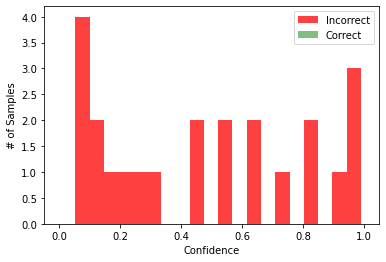

In [21]:
plt.hist(out[out.Result==False].Conf, color='red', bins=20, alpha=0.75)
plt.hist(out[out.Result==True].Conf, color='green', bins=20, alpha=0.5)
plt.ylabel('# of Samples')
plt.xlabel('Confidence')
plt.legend(['Incorrect','Correct'])
plt.show()

In [22]:
out.Result.value_counts()

False    23
Name: Result, dtype: int64

Actual:	 10
Guess:	 Thene
Conf:	  0.7385509610176086
	 False


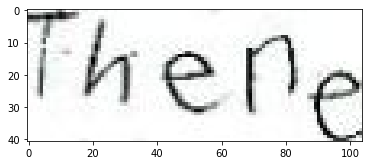

***************************************************************************************************************
Actual:	 14
Guess:	 were
Conf:	  0.6480907797813416
	 False


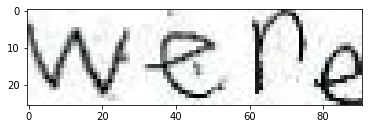

***************************************************************************************************************
Actual:	 15
Guess:	 t0
Conf:	  0.5407399535179138
	 False


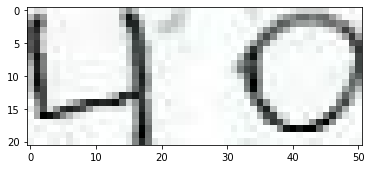

***************************************************************************************************************
Actual:	 19
Guess:	 myffins
Conf:	  0.45492589473724365
	 False


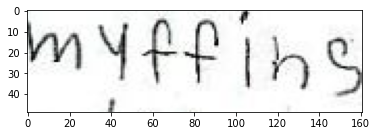

***************************************************************************************************************
Actual:	 20
Guess:	 to
Conf:	  0.9907636642456055
	 False


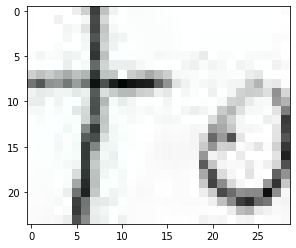

***************************************************************************************************************
Actual:	 21
Guess:	 begin
Conf:	  0.9003114700317383
	 False


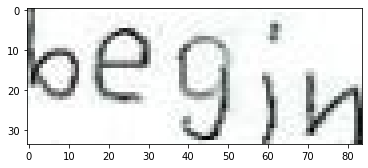

***************************************************************************************************************
Actual:	 25
Guess:	 with
Conf:	  0.8332096934318542
	 False


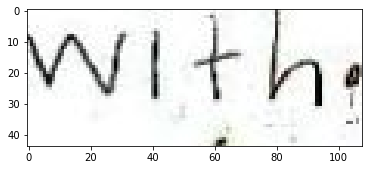

***************************************************************************************************************
Actual:	 26
Guess:	 26tIOT
Conf:	  0.07863808423280716
	 False


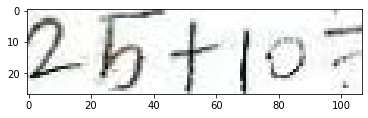

***************************************************************************************************************
Actual:	 27
Guess:	 'h
Conf:	  0.2779366970062256
	 False


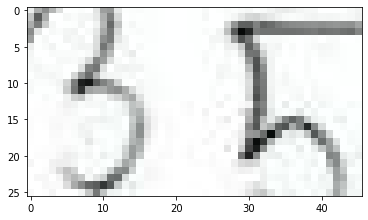

***************************************************************************************************************
Actual:	 31
Guess:	 .
Conf:	  0.5406997799873352
	 False


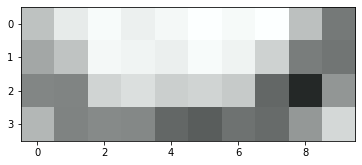

***************************************************************************************************************
Actual:	 35
Guess:	 35t
Conf:	  0.6555044651031494
	 False


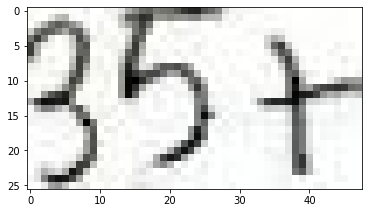

***************************************************************************************************************
Actual:	 36
Guess:	 5-40
Conf:	  0.1716519594192505
	 False


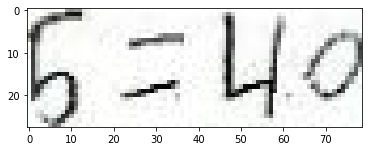

***************************************************************************************************************
Actual:	 4
Guess:	 td
Conf:	  0.09982122480869293
	 False


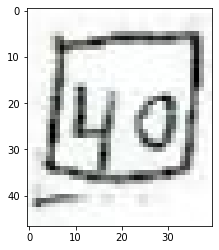

***************************************************************************************************************
Actual:	 40
Guess:	 I
Conf:	  0.9905410408973694
	 False


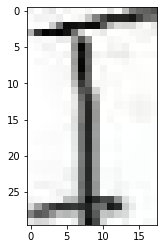

***************************************************************************************************************
Actual:	 41
Guess:	 kniow
Conf:	  0.8077805042266846
	 False


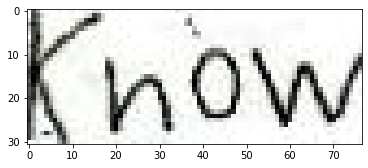

***************************************************************************************************************
Actual:	 42
Guess:	 26
Conf:	  0.4626476764678955
	 False


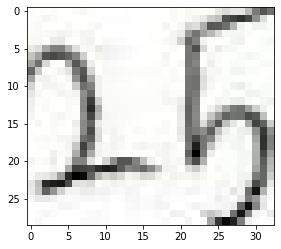

***************************************************************************************************************
Actual:	 43
Guess:	 Fis
Conf:	  0.33182573318481445
	 False


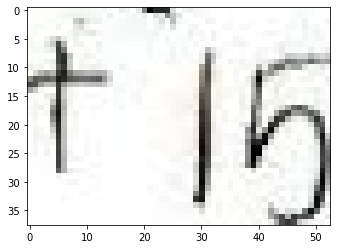

***************************************************************************************************************
Actual:	 44
Guess:	 g4O
Conf:	  0.12166360765695572
	 False


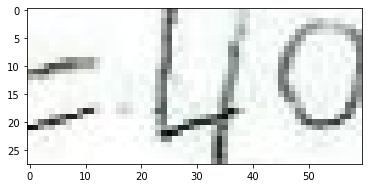

***************************************************************************************************************
Actual:	 48
Guess:	 2
Conf:	  0.23044690489768982
	 False


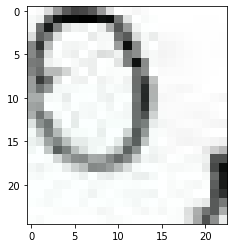

***************************************************************************************************************
Actual:	 49
Guess:	 4o
Conf:	  0.9520983695983887
	 False


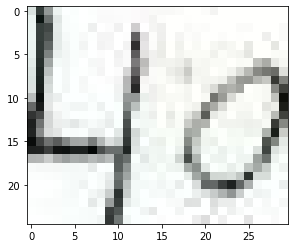

***************************************************************************************************************
Actual:	 5
Guess:	 2b
Conf:	  0.07667333632707596
	 False


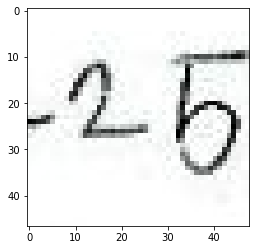

***************************************************************************************************************
Actual:	 50
Guess:	 251
Conf:	  0.05190525949001312
	 False


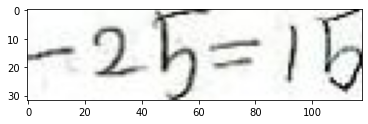

***************************************************************************************************************
Actual:	 6
Guess:	 2ls
Conf:	  0.05715200677514076
	 False


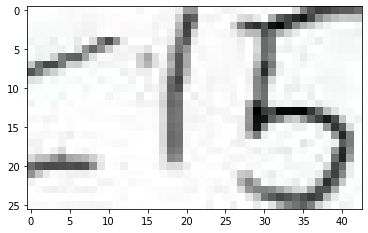

***************************************************************************************************************


In [23]:
%matplotlib inline

for tup in out.itertuples():
    print('Actual:\t', tup.Actual)
    print('Guess:\t', tup.Guess)
    print('Conf:\t ', tup.Conf)
    print('\t', tup.Result)
    im = Image.open(tup.Path)
    imshow(np.asarray(im))
    plt.show()
    print('***************************************************************************************************************')